In [2]:
!pip install gensim wordcloud

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
plt.rcParams["figure.dpi"] = 120

# Upload file: events_set1_combined_clean.tsv
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)
df = pd.read_csv(filename, sep="\t")
print("Columns:", df.columns.tolist())
print(df.head())


Saving events_set1_combined_clean.tsv to events_set1_combined_clean.tsv
Uploaded file: events_set1_combined_clean.tsv
Columns: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean']
             tweet_id                                         tweet_text  \
0  798262465234542592  RT @MissEarth: New Zealand need our prayers af...   
1  771464543796985856  @johnaglass65 @gordonluke Ah, woke up to a nig...   
2  797835622471733248  RT @terremotocentro: #eqnz if you need a tool ...   
3  798021801540321280  RT @BarristerNZ: My son (4) has drawn a pictur...   
4  798727277794033664  Due to earthquake damage our Defence Force is ...   

                         class_label     place    Disaster  year split  \
0               sympathy_and_support  kaikoura  earthquake  2016   dev   
1                 caution_and_advice  kaikoura  earthquake  2016   dev   
2           requests_or_urgent_needs  kaikoura  earthquake  2016   dev   
3         other_relevant_i

In [3]:
# Tokens
df["text_clean"] = df["text_clean"].astype(str)
df["tokens"] = df["text_clean"].str.split()
df[["text_clean", "tokens"]].head()

,text_clean,tokens
0,new zealand need our prayers after the devasta...,"[new, zealand, need, our, prayers, after, the,..."
1,ah woke up to a nightmare 1 earthquake on the ...,"[ah, woke, up, to, a, nightmare, 1, earthquake..."
2,eqnz if you need a tool for a rapid crowdsourc...,"[eqnz, if, you, need, a, tool, for, a, rapid, ..."
3,my son 4 has drawn a picture of todays earthqu...,"[my, son, 4, has, drawn, a, picture, of, today..."
4,due to earthquake damage our defence force is ...,"[due, to, earthquake, damage, our, defence, fo..."


In [6]:
import re

# Stopwords list
stopwords = {
    "the","a","an","and","or","of","in","on","at","to","for","from","by","with",
    "this","that","is","are","was","were","be","been","it","as","about","rt",
    "i","you","he","she","we","they","them","me","my","your","our","their",
    "so","if","but","not","no","yes","do","did","does","can","could","will","would",
    "just","up","down","out","over","under",
    "im","ive","dont","cant","didnt","doesnt","youre","youve","youll","hes","shes"
}

df["text_clean"] = df["text_clean"].astype(str)

def clean_and_tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
    return tokens

df["tokens"] = df["text_clean"].apply(clean_and_tokenize)

df[["text_clean", "tokens"]].head()


,text_clean,tokens
0,new zealand need our prayers after the devasta...,"[new, zealand, need, prayers, after, devastati..."
1,ah woke up to a nightmare 1 earthquake on the ...,"[woke, nightmare, earthquake, east, coast, tsu..."
2,eqnz if you need a tool for a rapid crowdsourc...,"[eqnz, need, tool, rapid, crowdsourcing, info,..."
3,my son 4 has drawn a picture of todays earthqu...,"[son, has, drawn, picture, todays, earthquake,..."
4,due to earthquake damage our defence force is ...,"[due, earthquake, damage, defence, force, work..."


In [7]:
# Fig 5
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Find year
years_all = sorted(df["year"].dropna().unique())
print("All years in dataset:", years_all)

# 2016–2018
years_to_use = [y for y in years_all if 2016 <= y <= 2018]
print("Years used for LDA:", years_to_use)

lda_results = {}

for year in years_to_use:
    df_year = df[df["year"] == year]
    texts = df_year["tokens"].tolist()
    print(f"\n=== Year {year}, tweets: {len(texts)} ===")
    if len(texts) < 50:
        print("Too few tweets for LDA, skip this year.")
        continue

    # Build dictionary and corpus
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(t) for t in texts]

    # Run LDA, 5 topics
    num_topics = 5
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42,
    )

    lda_results[year] = (lda, dictionary, corpus)
    for topic_id in range(num_topics):
        words = lda.show_topic(topic_id, topn=6)
        pretty = ", ".join([f"{w} ({p:.3f})" for w, p in words])
        print(f"Year {year} - Topic {topic_id}: {pretty}")

All years in dataset: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]
Years used for LDA: [np.int64(2016), np.int64(2017), np.int64(2018)]

=== Year 2016, tweets: 8855 ===
Year 2016 - Topic 0: earthquake (0.041), new (0.026), eqnz (0.026), tsunami (0.022), damage (0.018), after (0.017)
Year 2016 - Topic 1: all (0.047), affected (0.045), prayers (0.043), thoughts (0.039), earthquake (0.033), those (0.029)
Year 2016 - Topic 2: haiti (0.157), hurricane (0.131), matthew (0.088), people (0.018), hurricanematthew (0.016), after (0.014)
Year 2016 - Topic 3: wildfire (0.093), fort (0.044), mcmurray (0.041), help (0.038), donate (0.038), relief (0.030)
Year 2016 - Topic 4: italyearthquake (0.034), victims (0.030), earthquake (0.029), help (0.022), ecuador (0.020), efforts (0.012)

=== Year 2017, tweets: 28364 ===
Year 2017 - Topic 0: flood (0.058), srilanka (0.048), floodsl (0.043), hurricaneirma (0.031), lka (0.025), sri (0.025)
Year 2017 - Topic 1: irma (0.069), hurricane (0.

In [12]:
# Find Harvey
mask_harvey_text = df["tweet_text"].astype(str).str.contains("harvey", case=False, na=False)

# Hurrican + Harvey
mask_harvey = (
    df["Disaster"].astype(str).str.lower().eq("hurricane")
    & mask_harvey_text
)

df_harvey = df[mask_harvey].copy()
print("Harvey:", len(df_harvey))

df_harvey[["tweet_text", "Disaster"]].head(10)

Harvey: 8515


,tweet_text,Disaster
2196,"After #Harvey, we need to re-think the messagi...",hurricane
2197,A second person was killed on Saturday as Harv...,hurricane
2198,DETAILS: #Evacuation order issued for those wi...,hurricane
2199,Join us &amp; the @phoenixsaloon for a special...,hurricane
2200,Meet one of MANY volunteers up here in #Kingwo...,hurricane
2201,RT @HuffPost: Harvey spawns tornadoes that dev...,hurricane
2202,Our thoughts &amp; #prayers are with those aff...,hurricane
2203,@kgdewitt24 Ive been wanting to complain this ...,hurricane
2204,Our sons house destroyed by Harvey.Lost everyt...,hurricane
2205,Some journalists covering #Harvey cast aside r...,hurricane


Harvey-related tweets: 8515

Hashtag + topic：
            hashtag  count    hashtag_lower                  topic
29         beaumont     28         beaumont                 Others
28           khou11     28           khou11                 Others
27            trump     29            trump                Mexican
26             maga     30             maga                 Others
25         redcross     32         redcross  Support and Donations
24    climatechange     34    climatechange                 Others
23           floods     37           floods  Floods and Hurricanes
22          harveys     37          harveys                 Others
21            flood     37            flood  Floods and Hurricanes
20         breaking     39         breaking                 Others
19    houstonfloods     43    houstonfloods  Floods and Hurricanes
18             news     44             news                 Others
16     harveyrelief     45     harveyrelief  Support and Donations
17       portart

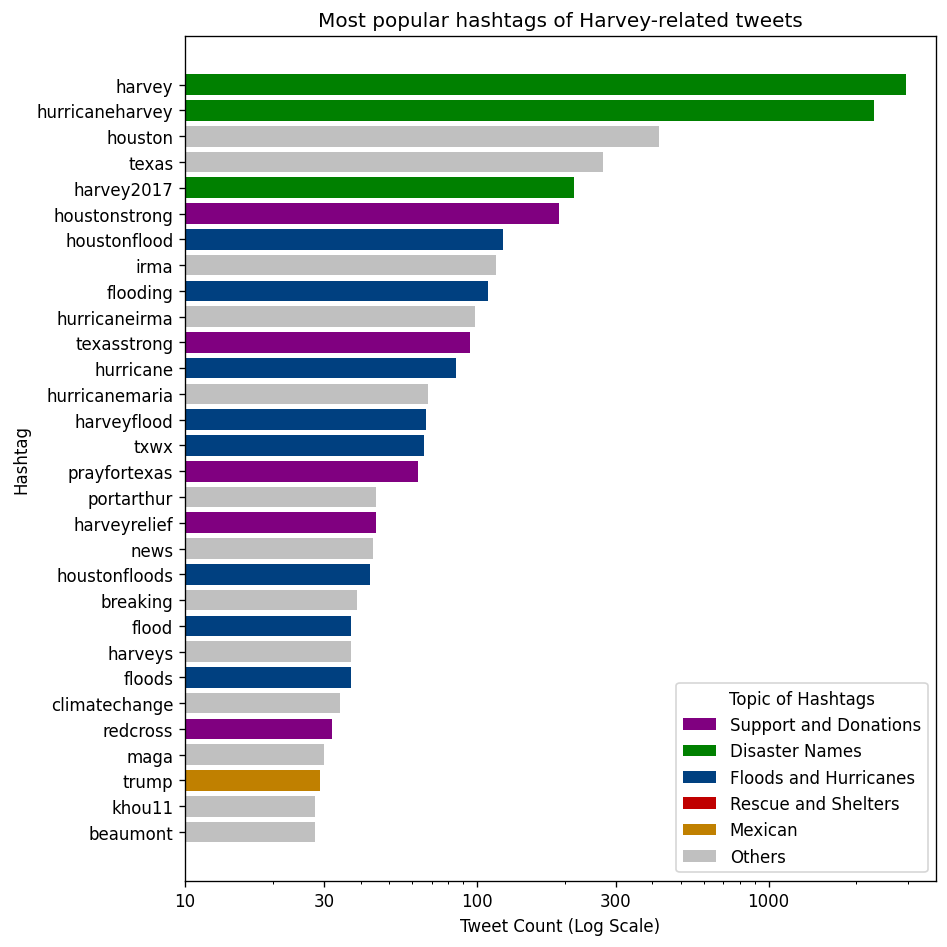

In [15]:
# Fig 6
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.rcParams["figure.dpi"] = 120

# Refuilter Harvey related
mask_harvey_text = df["tweet_text"].astype(str).str.contains("harvey", case=False, na=False)
mask_hurricane   = df["Disaster"].astype(str).str.lower().eq("hurricane")
mask_harvey      = mask_harvey_text & mask_hurricane

df_harvey = df[mask_harvey].copy()
print("Harvey-related tweets:", len(df_harvey))

# hashtag：#xxx → "xxx"
def extract_hashtags_from_text(text: str):
    if not isinstance(text, str):
        return []
    return re.findall(r"#(\w+)", text.lower())

df_harvey["hashtags"] = df_harvey["tweet_text"].apply(extract_hashtags_from_text)

# Compute hashtags frequency
counter = Counter()
for tags in df_harvey["hashtags"]:
    counter.update(tags)

TOP_K = 30
most_common = counter.most_common(TOP_K)

if len(most_common) == 0:
    print("no")
else:
    # Build DataFrame
    hashtag_df = pd.DataFrame(most_common, columns=["hashtag", "count"])
    hashtag_df["hashtag_lower"] = hashtag_df["hashtag"].str.lower()

    # Topics
    manual_topic_map = {
        # Disaster Names（Green）
        "harvey":                  "Disaster Names",
        "hurricaneharvey":         "Disaster Names",
        "harvey2017":              "Disaster Names",

        # Support and Donations（Purple）
        "houstonstrong":           "Support and Donations",
        "texasstrong":             "Support and Donations",
        "prayfortexas":            "Support and Donations",
        "harveyrelief":            "Support and Donations",
        "hurricaneharveyrelief":   "Support and Donations",
        "redcross":                "Support and Donations",

        # Floods and Hurricanes（Blue）
        "flooding":                "Floods and Hurricanes",
        "flood":                   "Floods and Hurricanes",
        "floods":                  "Floods and Hurricanes",
        "houstonflood":            "Floods and Hurricanes",
        "houstonfloods":           "Floods and Hurricanes",
        "houstonflooding":         "Floods and Hurricanes",
        "harveyflood":             "Floods and Hurricanes",
        "harveystorm":             "Floods and Hurricanes",
        "hurricane":               "Floods and Hurricanes",
        "txwx":                    "Floods and Hurricanes",
        "tornado":                 "Floods and Hurricanes",

        # Rescue and Shelters（Red）
        "rescue":                  "Rescue and Shelters",
        "rescuedogs":              "Rescue and Shelters",
        "shelter":                 "Rescue and Shelters",
        "shelters":                "Rescue and Shelters",
        "evacuation":              "Rescue and Shelters",
        "evacuate":                "Rescue and Shelters",
        "firstresponders":         "Rescue and Shelters",
        "volunteers":              "Rescue and Shelters",

        # Mexican（Orange）
        "houmx":                   "Mexican",
        "mexico":                  "Mexican",
        "mexicocity":              "Mexican",
        "prayformexico":           "Mexican",
        "trump":           "Mexican",
    }

    hashtag_df["topic"] = hashtag_df["hashtag_lower"].map(
        lambda t: manual_topic_map.get(t, "Others")
    )

    # Frequancy from small to large
    hashtag_df = hashtag_df.sort_values("count", ascending=True)
    print("\nHashtag + topic：")
    print(hashtag_df)
    topic_palette = {
        "Support and Donations": "#800080",
        "Disaster Names":        "#008000",
        "Floods and Hurricanes": "#004080",
        "Rescue and Shelters":   "#C00000",
        "Mexican":               "#C08000",
        "Others":                "#C0C0C0",
    }

    colors = hashtag_df["topic"].map(lambda t: topic_palette.get(t, "#C0C0C0"))

    plt.figure(figsize=(8, 8))
    plt.barh(hashtag_df["hashtag"], hashtag_df["count"], color=colors)

    plt.xscale("log")
    plt.xlabel("Tweet Count (Log Scale)")
    plt.ylabel("Hashtag")
    plt.title("Most popular hashtags of Harvey-related tweets")
    plt.xticks([10, 30, 100, 300, 1000], [10, 30, 100, 300, 1000])

    legend_elements = [
        Patch(facecolor=topic_palette["Support and Donations"], label="Support and Donations"),
        Patch(facecolor=topic_palette["Disaster Names"],        label="Disaster Names"),
        Patch(facecolor=topic_palette["Floods and Hurricanes"], label="Floods and Hurricanes"),
        Patch(facecolor=topic_palette["Rescue and Shelters"],   label="Rescue and Shelters"),
        Patch(facecolor=topic_palette["Mexican"],               label="Mexican"),
        Patch(facecolor=topic_palette["Others"],                label="Others"),
    ]
    plt.legend(handles=legend_elements, title="Topic of Hashtags", loc="lower right")

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3810318072.py:44: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.datetime.utcfromtimestamp(timestamp_ms / 1000.0)


During Harvey tweets: 1206
After Harvey tweets: 7309
During: 2822
After: 9714


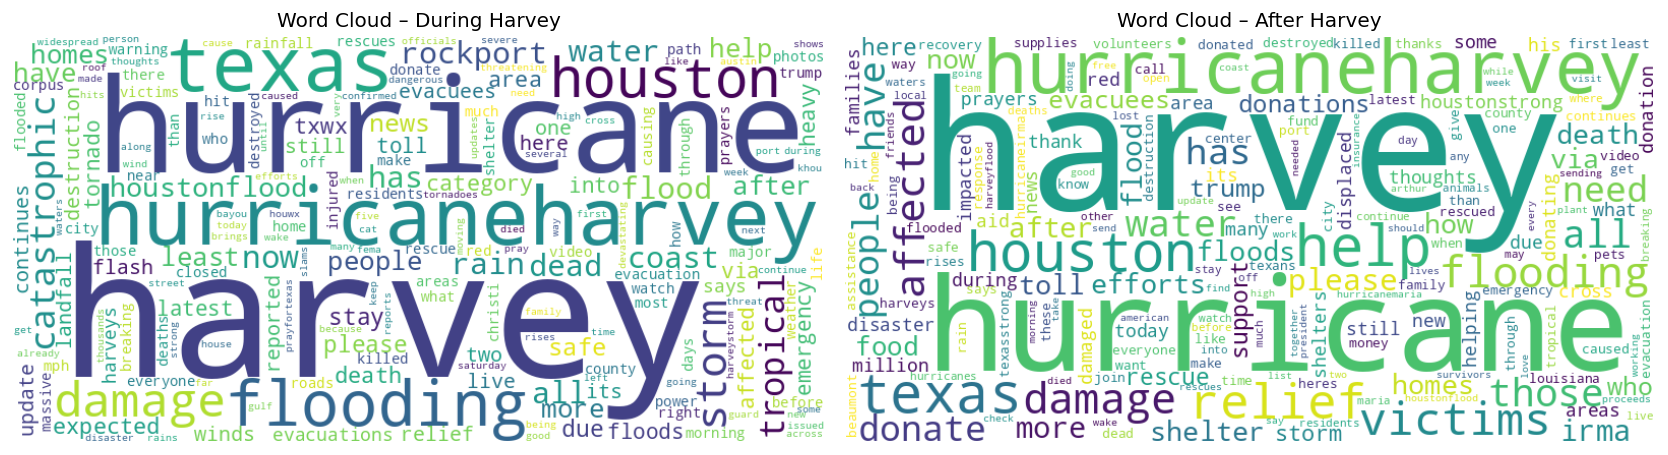

In [20]:
# Fig.7：During vs After Harvey
import datetime
import re
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.rcParams["figure.dpi"] = 120

if "tokens" not in df.columns:
    stopwords = {
        "the","a","an","and","or","of","in","on","at","to","for","from","by","with",
        "this","that","is","are","was","were","be","been","it","as","about","rt",
        "i","you","he","she","we","they","those","them","me","my","your","our","their",
        "so","if","but","not","no","yes","do","did","does","can","could","will","would",
        "just","up","down","out","over","under","have","all","some","these"
        "im","ive","dont","cant","didnt","doesnt","youre","youve","youll","hes","shes"
    }

    df["text_clean"] = df["text_clean"].astype(str)

    def clean_and_tokenize(text: str):
        text = text.lower()
        text = re.sub(r"[^a-z\s]", " ", text)
        tokens = text.split()
        tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
        return tokens

    df["tokens"] = df["text_clean"].apply(clean_and_tokenize)

mask_harvey_text = df["tweet_text"].astype(str).str.contains("harvey", case=False, na=False)
mask_hurricane   = df["Disaster"].astype(str).str.lower().eq("hurricane")
mask_harvey      = mask_harvey_text & mask_hurricane

df_harvey = df[mask_harvey].copy()

# Use tweet_id compute time（Twitter snowflake）
TWITTER_EPOCH_MS = 1288834974657  # 2010-11-04 01:42:54 UTC

def tweet_id_to_datetime(tweet_id):
    tid = int(tweet_id)
    timestamp_ms = (tid >> 22) + TWITTER_EPOCH_MS
    return datetime.datetime.utcfromtimestamp(timestamp_ms / 1000.0)

# Turn into int
df_harvey["tweet_id"] = df_harvey["tweet_id"].astype(str)
df_harvey["created_at"] = df_harvey["tweet_id"].apply(tweet_id_to_datetime)

# Pick“During / After Harvey”boundary 2017-08-29
pivot_date = datetime.datetime(2017, 8, 29)
df_during = df_harvey[df_harvey["created_at"] <= pivot_date]
df_after  = df_harvey[df_harvey["created_at"] > pivot_date]

print("During Harvey tweets:", len(df_during))
print("After Harvey tweets:", len(df_after))

# Word frequency
def get_word_freq(df_part):
    all_tokens = []
    for tokens in df_part["tokens"]:
        all_tokens.extend(tokens)
    return Counter(all_tokens)

freq_during = get_word_freq(df_during)
freq_after  = get_word_freq(df_after)

print("During:", len(freq_during))
print("After:", len(freq_after))

wc_during = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(freq_during)

wc_after = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(freq_after)

# Fig.7
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_during, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – During Harvey")

plt.subplot(1, 2, 2)
plt.imshow(wc_after, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – After Harvey")

plt.tight_layout()
plt.show()